# Human Activity Recognition
***Reynaldo Vazquez***  
***April, 2018***


## Tests various classification algorithms to detect human activity from accelerometer and gyroscope data

<img src="media/walking_woman_emoji.png" style="width:160px;height:160px;" align="left">


The best performing algorithm is a GBM Classifier with **99.4% accuracy** and average precision, recall, and F1 of over 99% on 6 classes. This algorithm is also able to make predictions relatively fast.

Other classifiers tested include Logistic Regression, Multilayer Perceptron Network, Random Forest, K-Nearest, and Linear Support Vector Machine. In all models, most misclassifications occurred between activities in which the subject was not in motion and not standing, although they all correctly determined the subject was not in motion in all of the misclassified instances. For activities involving motion, the predictive ability of all models reported here is perfect or near perfect. The prediction time for the trained models vary considerably, so prediction time can be an important factor at determining the best model.

The data comes from Anguita et al., (2013) and was collected from a group of 30 volunteers who performed six activities (walking, walking upstairs, walking downstairs, sitting, standing, laying), wearing a smartphone on the waist. Three-axes linear acceleration and angular velocity were captured using the smartphone's  built-in accelerometer and gyroscope. The activities were video-recorded to label the data manually. The original dataset and more information can be found at the authors' [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). For this analysis, the data was downloaded from [Kaggle](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/data). 

The original datasets were resampled here to allow for more training examples. Subject identities were strapped from the datasets to prevent data leakeage and to honor the data authors' original intention of keeping the features datasets anonymous.

### Packages

In [1]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC
import sklearn.neural_network as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from cm_heat_plots import *
import time
%matplotlib inline

### Data

In [2]:
har_zip = zipfile.ZipFile('har_smartphone.zip') 
print(har_zip.namelist())

['test.csv', 'train.csv']


In [3]:
df1 = pd.read_csv(har_zip.open('train.csv'))
df2 = pd.read_csv(har_zip.open('test.csv'))
# Join both sets for later resampling
full_data = pd.concat([df1, df2]) 
X_orig = full_data.loc[:, full_data.columns != 'Activity']
Y_orig = full_data['Activity']

In [4]:
df1 = pd.read_csv(har_zip.open('train.csv'))
df2 = pd.read_csv(har_zip.open('test.csv'))
# Join both sets for later resampling
all_data = pd.concat([df1, df2]) 
# Drop subject and activity for features dataset
X_all = all_data.drop(['subject', 'Activity'], axis=1)
Y_all = all_data['Activity']

#### Codify Y  labels

In [5]:
activities = Y_all.unique()
activities = [w.title() for w in list(activities)]
Y_coded = Y_all.astype("category", pd.api.types.CategoricalDtype(categories = 
                                                        activities)).cat.codes
activities = [w.replace("_", ' ') for w in activities]
activity_dict = dict(enumerate(activities))
print("Classes:")
print(", ".join(activities))

Classes:
Standing, Sitting, Laying, Walking, Walking Downstairs, Walking Upstairs


In [6]:
for label, activity in activity_dict.items():
    print("Number of", "\""+activity+"\"", "Examples --", sum(Y_coded == label))

Number of "Standing" Examples -- 1944
Number of "Sitting" Examples -- 1777
Number of "Laying" Examples -- 1906
Number of "Walking" Examples -- 1722
Number of "Walking Downstairs" Examples -- 1406
Number of "Walking Upstairs" Examples -- 1544


#### Split into train and test sets. Y_train, Y_test will be used throughout, while X_all_train, X_all_test will be further transformed (using PCA dimensionality reduction) to use in some specifications.

In [7]:
X_all_train, X_all_test, Y_train, Y_test = train_test_split(X_all ,Y_coded, test_size=1000,
                                                    random_state=1)

#### Reduce features dimension with PCA, whiten.

In [8]:
pca150_dec = decomposition.PCA(n_components = 150, whiten = True).fit(X_all_train)
X_pca150_train = pca150_dec.transform(X_all_train)
X_pca150_test = pca150_dec.transform(X_all_test)

#### Training and reporting function
Will train and return the trained specified model. Will print model preformance metrics.

In [9]:
def run_model(X_train, Y_train, X_test, Y_test, model):
    """
    Trains the specified model, calculates predictions, and returns and prints the
    classification report and accuracy metric.
    """
    print("Model:", str(model).split("(")[0], "\n")
    start_time = time.time()
    trained_model = model.fit(X_train, Y_train)
    elapsed_time = time.time() - start_time
    predicted_Y_test = trained_model.predict(X_test)
    predicted_Y_test = np.rint(predicted_Y_test)   ## Required by Random Forest
    predicted_Y_train = trained_model.predict(X_train)
    predicted_Y_train = np.rint(predicted_Y_train) ## ibid
    print("Classification report on test set \n")
    pred_activity = [activity_dict[label] for label in predicted_Y_test]
    actual_activity = [activity_dict[label] for label in Y_test]
    report = classification_report(pred_activity, actual_activity)
    train_acc = accuracy_score(predicted_Y_train, Y_train)
    test_acc =accuracy_score(predicted_Y_test, Y_test)
    print(report)
    print("Train Accuracy =", str(format(train_acc, '.3f')))
    print("Test Accuracy  =", str(format(test_acc, '.3f')))
    print("Training time:", int(elapsed_time), "seconds")
    return trained_model, report

### K-Nearest Neighbors

In [10]:
knn = KNeighborsClassifier(n_neighbors=1, p = 1)
knn_trained, knn_report = run_model(X_all_train, Y_train, X_all_test, Y_test, knn)

Model: KNeighborsClassifier 

Classification report on test set 

                    precision    recall  f1-score   support

            Laying       0.97      0.95      0.96       192
           Sitting       0.95      0.97      0.96       178
          Standing       0.99      1.00      1.00       172
           Walking       1.00      1.00      1.00       171
Walking Downstairs       1.00      1.00      1.00       141
  Walking Upstairs       1.00      1.00      1.00       146

       avg / total       0.99      0.98      0.98      1000

Train Accuracy = 1.000
Test Accuracy  = 0.985
Training time: 0 seconds


### Multilayer Perceptron Neural Network

In [11]:
mlp =  nn.MLPClassifier(hidden_layer_sizes=(80,), max_iter=500, 
                            alpha=.008, solver='adam', tol=1e-5, random_state=1,
                            learning_rate_init=.0005, beta_1 = 0.85,
                            beta_2 = 0.9992, epsilon = 1e-8) 
mlp_trained, mlp_report = run_model(X_pca150_train, Y_train, X_pca150_test, Y_test, mlp)

Model: MLPClassifier 

Classification report on test set 

                    precision    recall  f1-score   support

            Laying       0.97      0.96      0.97       191
           Sitting       0.96      0.97      0.96       178
          Standing       1.00      1.00      1.00       173
           Walking       1.00      1.00      1.00       171
Walking Downstairs       1.00      1.00      1.00       141
  Walking Upstairs       1.00      1.00      1.00       146

       avg / total       0.99      0.99      0.99      1000

Train Accuracy = 1.000
Test Accuracy  = 0.987
Training time: 18 seconds


### Random Forest

In [12]:
rf = RandomForestRegressor(random_state = 0)
rf_trained, rf_report = run_model(X_all_train, Y_train, X_all_test, Y_test, rf)

Model: RandomForestRegressor 

Classification report on test set 

                    precision    recall  f1-score   support

            Laying       0.94      0.92      0.93       193
           Sitting       0.91      0.94      0.92       176
          Standing       1.00      1.00      1.00       173
           Walking       0.97      0.99      0.98       167
Walking Downstairs       0.96      0.92      0.94       148
  Walking Upstairs       0.95      0.97      0.96       143

       avg / total       0.96      0.95      0.95      1000

Train Accuracy = 0.994
Test Accuracy  = 0.955
Training time: 40 seconds


### Stochastic Gradient Descent

In [13]:
sgd = SGDClassifier(alpha = 0.00001, random_state = 1, tol = 1e-5)
sgd_trained, sgd_report = run_model(X_pca150_train, Y_train, X_pca150_test, Y_test, sgd)

Model: SGDClassifier 

Classification report on test set 

                    precision    recall  f1-score   support

            Laying       0.95      0.94      0.94       191
           Sitting       0.93      0.95      0.94       178
          Standing       1.00      1.00      1.00       173
           Walking       1.00      1.00      1.00       171
Walking Downstairs       1.00      1.00      1.00       141
  Walking Upstairs       1.00      1.00      1.00       146

       avg / total       0.98      0.98      0.98      1000

Train Accuracy = 0.987
Test Accuracy  = 0.979
Training time: 0 seconds


### Gradient Boosting

In [14]:
gbm = GradientBoostingClassifier(learning_rate=0.5, n_estimators=150, max_depth=3)
gbm_trained, gbm_report = run_model(X_all_train, Y_train, X_all_test, Y_test, gbm)

Model: GradientBoostingClassifier 

Classification report on test set 

                    precision    recall  f1-score   support

            Laying       0.99      0.98      0.98       190
           Sitting       0.98      0.99      0.98       179
          Standing       1.00      1.00      1.00       173
           Walking       1.00      1.00      1.00       171
Walking Downstairs       1.00      1.00      1.00       141
  Walking Upstairs       1.00      1.00      1.00       146

       avg / total       0.99      0.99      0.99      1000

Train Accuracy = 1.000
Test Accuracy  = 0.994
Training time: 191 seconds


### Logistic Regression

In [15]:
lr = LogisticRegression(penalty = 'l1', tol = 1e-4, C = 1)
lr_trained, lr_report = run_model(X_all_train, Y_train, X_all_test, Y_test, lr)

Model: LogisticRegression 

Classification report on test set 

                    precision    recall  f1-score   support

            Laying       0.96      0.95      0.96       191
           Sitting       0.94      0.97      0.96       177
          Standing       1.00      1.00      1.00       173
           Walking       1.00      0.99      1.00       172
Walking Downstairs       1.00      1.00      1.00       141
  Walking Upstairs       1.00      1.00      1.00       146

       avg / total       0.98      0.98      0.98      1000

Train Accuracy = 0.989
Test Accuracy  = 0.983
Training time: 8 seconds


### Linear Support Vector Machine

In [16]:
lsvc = LinearSVC(random_state = 1, C = 0.1)
lsvc_trained, lsvc_report = run_model(X_all_train, Y_train, X_all_test, Y_test, lsvc)

Model: LinearSVC 

Classification report on test set 

                    precision    recall  f1-score   support

            Laying       0.95      0.95      0.95       188
           Sitting       0.95      0.95      0.95       181
          Standing       1.00      1.00      1.00       173
           Walking       1.00      1.00      1.00       171
Walking Downstairs       1.00      0.99      1.00       142
  Walking Upstairs       0.99      1.00      1.00       145

       avg / total       0.98      0.98      0.98      1000

Train Accuracy = 0.990
Test Accuracy  = 0.981
Training time: 6 seconds


### Prediction Time and Confusion Matrices

In [17]:
plot_labels = ['Standing',
 'Sitting',
 'Laying',
 'Walking',
 'Walking\nDownstairs',
 'Walking\nUpstairs']

In [18]:
def predict_and_time(trained_model, X):
    """
    Calculates predictions and prints the time elapsed to make the predictions
    Args:
        trained_model: a trained (sklearn) model 
        X: a set of features
    Returns:
        predictions
    """
    model_name = str(trained_model).split("(")[0]
    start_time = time.time()
    predictions = trained_model.predict(X)
    elapsed_time = time.time() - start_time
    predictions = np.rint(predictions)   # Required by Random Forest
    print("Time to calculate", X.shape[0], "predictions with", model_name, "model:", 
          str(format(elapsed_time, '.4f')), "seconds")
    return predictions

In [19]:
knn_predictions = predict_and_time(knn_trained, X_all_test)

Time to calculate 1000 predictions with KNeighborsClassifier model: 8.0982 seconds


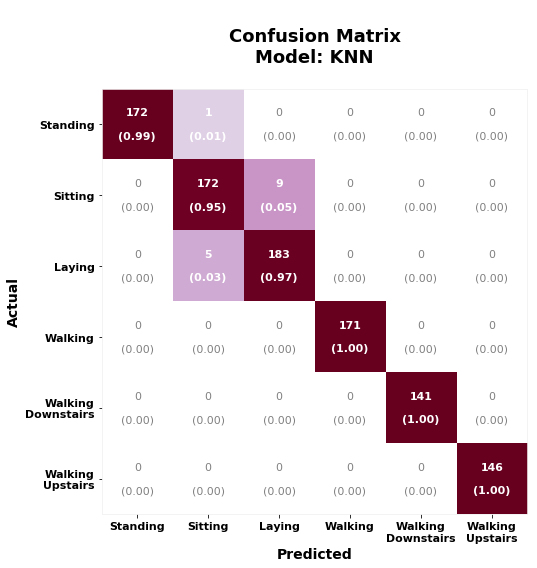

In [20]:
cm_knn = confusion_matrix(Y_test, knn_predictions)
heated_confusion_matrix(cm = cm_knn, labels = plot_labels, cmap = plt.cm.PuRd, 
                        contrast = 3, model_name = "KNN")

In [21]:
gbm_predictions = predict_and_time(gbm_trained, X_all_test)

Time to calculate 1000 predictions with GradientBoostingClassifier model: 0.0265 seconds


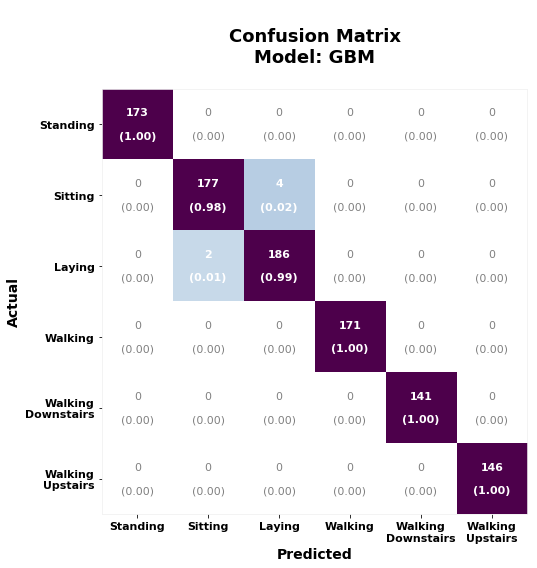

In [22]:
cm_gbm = confusion_matrix(Y_test, gbm_predictions)
heated_confusion_matrix(cm = cm_gbm, labels = plot_labels, cmap = plt.cm.BuPu, 
                        contrast = 3, model_name = "GBM", save_fig = True)

In [23]:
mlp_predictions = predict_and_time(mlp_trained, X_pca150_test)

Time to calculate 1000 predictions with MLPClassifier model: 0.0109 seconds


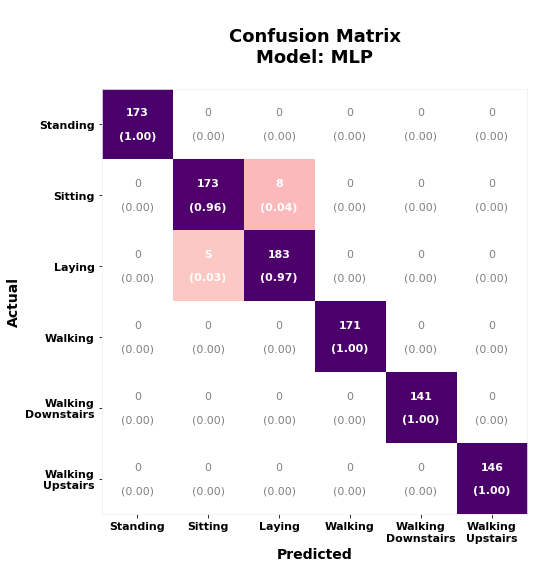

In [24]:
cm_mlp = confusion_matrix(Y_test, mlp_predictions)
heated_confusion_matrix(cm = cm_mlp, labels = plot_labels, cmap = plt.cm.RdPu, 
                           contrast = 2.5, model_name = "MLP")

### Conclusion

The best performing algorithm in terms of predictive ability was a Gradient Boosting specification which achieved 99.4% accuracy. However, other algorithms were able to train much faster and still attain good performance. For example, a K-Nearest-Neighbors algorithm performed with 98.5% accuracy in less than 1 second, however, prediction time in this model is quite long. The Multilayer Perceptron model trains relatively fast and is able to produce 1000 predictions in a few milliseconds. In all models, most misclassifications occurred among activities in which the subject was not in motion. More specifically, the algorithms the most problem determining whether the person was sitting or laying down, although they correctly determined the subject was still. For activities involving motion, the predictive ability of the models is perfect or near perfect.

### Reference:

**Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz**. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.